In [1]:
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import theano.tensor as tt
from theano import shared
import pandas as pd
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA, KernelPCA
from Plot_XZ import *
from PCA import *

In [2]:
np.set_printoptions(precision=0, suppress=True)
Savefig = 0 # 控制图形显示存储

elec_data = pd.read_csv('XZmulti_6.csv')

# 计算同一公司产品测试地点数目：
companies_num = elec_data.counts.unique()
companies = len(companies_num)  # companies=7， 共7个测试地点
company_lookup = dict(zip(companies_num, range(len(companies_num))))
company = elec_data['company_code'] = elec_data.counts.replace(company_lookup).values  # 加一行数据在XZsingal文件中
# companys = elec_data.counts.values - 1 # 这一句以上面两行功能相同

# 计算不同公司数目
company_ABC = elec_data.company.unique()
companiesABC = len(company_ABC)  # companies=7， 共7个测试地点
company_lookup_ABC = dict(zip(company_ABC, range(len(company_ABC))))
companyABC = elec_data['company_ABC'] = elec_data.company.replace(company_lookup_ABC).values  # 加一行数据在XZsingal文件中
# companys = elec_data.counts.values - 1 # 这一句以上面两行功能相同
# elec_count = elec_data.counts.values

# 给所有特征因素加上高斯噪声
SNR = np.random.normal(0, 2, size=[len(elec_data.Year.values), 4])

# #特征因素分析
elec_tem = elec_data.Tem.values + SNR[:, 0] # 观测温度值x2
elec_tem1 = (elec_tem - np.mean(elec_tem)) / np.std(elec_tem)
elec_hPa = elec_data.hPa.values + SNR[:, 1]  # 观测压强x3
elec_hPa1 = (elec_hPa - np.mean(elec_hPa)) / np.std(elec_hPa)
elec_RH = elec_data.RH.values + SNR[:, 2] # 观测压强x3
elec_RH1 = (elec_RH - np.mean(elec_RH)) / np.std(elec_RH)
elec_Lux = elec_data.Lux.values + SNR[:, 3] # 观测压强x3
elec_Lux1 = (elec_Lux - np.mean(elec_Lux)) / np.std(elec_Lux)

elec_Pca = np.vstack((elec_tem1, elec_hPa1, elec_RH1, elec_Lux1)).T   # 特征数据合并为一个数组
# elec_Pca2 = np.vstack((elec_tem, elec_hPa, elec_RH, elec_Lux)).T   # 特征数据合并为一个数组
# np.savetxt('XZ_nomean.csv', elec_Pca2, delimiter = ',')
# =============================================================================================
# # PCA特征降维，减少相关性，有两种方法，一种是自带函数，一种是网上程序，下面注释为网上程序
# x, z= pcaa(elec_Pca);  XX = np.array(x); ZZ = np.array(z)
# 将温度等4个特征降维变成2个特征，贡献率为99%以上，满足信息要求; 转换后的特征经过模型后能否还原
# =============================================================================================
# #白化，使得每个特征具有相同的方差，减少数据相关性，n_components：控制特征量个数
pca = PCA(n_components=0.995)
pca.fit(elec_Pca)
# 将数据X转换成降维后的数据。当模型训练好后，对于新输入的数据，都可以用transform方法来降维。
elec_Pca1 = pca.transform(elec_Pca)
elec_Pca1 = np.array(elec_Pca1)

# print(elec_Pca1)
# print(elec_Pca)
elec_Pca_char1 = elec_Pca1[:, 0] # 降维特征1
elec_Pca_char2 = elec_Pca1[:, 1] # 降维特征2
# print(elec_Pca_char1)

x, z= pcaa(elec_Pca)

# 计算观测时间，温度，光照等环境条件
elec_year = elec_data.Year.values  # 观测时间值x1
elec_year1 = (elec_year - np.mean(elec_year)) / np.std(elec_year)
# 计算故障率大小：故障数目/总测量数，作为模型Y值，放大100倍以增加实际效果，结果中要缩小100倍
elec_faults = 100 * (elec_data.Fault.values / elec_data.Nums.values)  # 数组形式,计算故障率大小

elec_faults2 = np.array([elec_faults[i*6:(i+1)*6] for i in np.arange(21)])
elec_year2 = np.array([elec_year[i*6:(i+1)*6] for i in np.arange(21)])

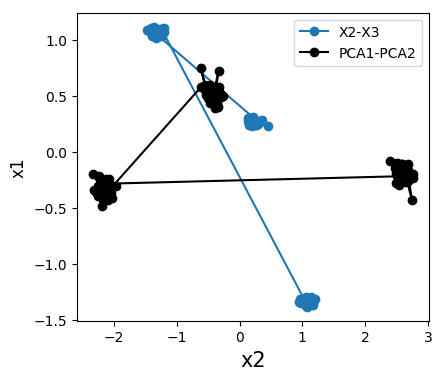

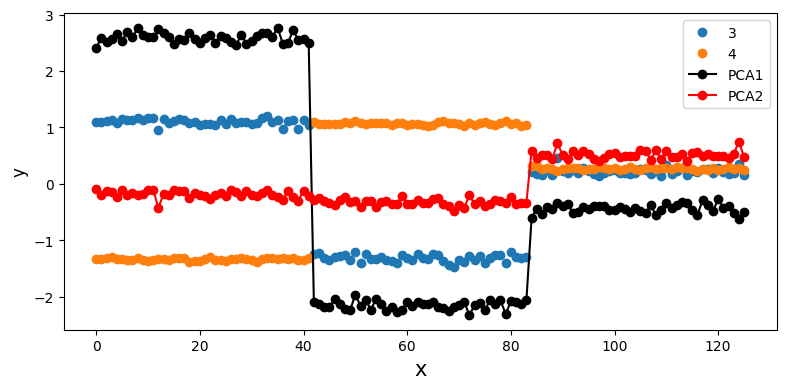

In [3]:
from matplotlib import gridspec
# 最后两个变量因素的主成分最大。故只画出最后两个的图
fig = plt.figure(figsize=(10, 4))
gs = gridspec.GridSpec(1, 2)
ip=1
ax = plt.subplot(gs[ip])
# for i in np.arange(3):
# ax.plot(elec_Pca[:, 2],elec_Pca[:, 0],'o')
# ax.plot(elec_Pca[:, 2],elec_Pca[:, 1],'o')
ax.plot(elec_Pca[:, 2],elec_Pca[:, 3],'o-')
# ax.plot(elec_Pca[:, 0],elec_Pca[:, (i+1)],'o')

ax.plot(elec_Pca1[:, 0], elec_Pca1[:, 1], 'ko-')
plt.legend([ 'X2-X3', 'PCA1-PCA2'], loc='upper right')
    
plt.xlabel('x2', fontsize=15)
plt.ylabel('x1', fontsize=12)
plt.show()


fig = plt.figure(figsize=(8, 4))
gs = gridspec.GridSpec(1, 1)
for ip in np.arange(1):
    ax = plt.subplot(gs[ip])
    for i in np.arange(2):
        ax.plot(elec_Pca[:, (i+2)],'o')

    ax.plot(elec_Pca1[:, ip], 'ko-')
    ax.plot(elec_Pca1[:, ip+1], 'ro-')
    plt.legend([ '3', '4', 'PCA1','PCA2'], loc='upper right')
    plt.xlabel('x', fontsize=15)
    plt.ylabel('y', fontsize=12)
plt.tight_layout()
plt.show()

In [42]:
# 应用偏最小二乘PLS来进行仿真
from sklearn.cross_decomposition import PLSRegression
X_PLSR = np.vstack((elec_year, elec_tem, elec_hPa, elec_RH, elec_Lux)).T   # 特征数据合并为一个数组
X_PLSR_XZ = X_PLSR[:42, :]
X_PLSR_XJ = X_PLSR[42:84, :]
X_PLSR_HLJ = X_PLSR[84:, :]
# X_PLSR_HLJ[:5, 0]=7
# print(X_PLSR_HLJ)
Y_PLSR = elec_faults
Y_PLSR_XZ = Y_PLSR[:42]
Y_PLSR_XJ = Y_PLSR[42:84]
Y_PLSR_HLJ = Y_PLSR[84:]
# print(Y_PLSR_XZ)


pls_XZ = PLSRegression(n_components=2)
pls_XZ.fit(X_PLSR_XZ, Y_PLSR_XZ)
# X_train_r, Y_train_r = pls_XZ.transform(X_PLSR_XZ, Y_PLSR_XZ)
# PLSRegression(copy=True, max_iter=500, n_components=2, scale=True, tol=1e-06)
Y_PLSpred_XZ = pls_XZ.predict(X_PLSR_XZ)
Y_PLSpred_XZ =  np.vstack((Y_PLSpred_XZ).T)[0]
# print(X_train_r)
# print(Y_PLSpred_XZ)

pls_XJ = PLSRegression(n_components=2)
pls_XJ.fit(X_PLSR_XJ, Y_PLSR_XJ)
# X_train_r, Y_train_r = pls_XZ.transform(X_PLSR_XZ, Y_PLSR_XZ)
# PLSRegression(copy=True, max_iter=500, n_components=2, scale=True, tol=1e-06)
Y_PLSpred_XJ = pls_XJ.predict(X_PLSR_XJ)
Y_PLSpred_XJ =  np.vstack((Y_PLSpred_XJ).T)[0]
# print(X_train_r)
# print(Y_PLSpred_XJ)


pls_HLJ = PLSRegression(n_components=2)
pls_HLJ.fit(X_PLSR_HLJ, Y_PLSR_HLJ)
# X_train_r, Y_train_r = pls_XZ.transform(X_PLSR_HLJ, Y_PLSR_HLJ)
# PLSRegression(copy=True, max_iter=500, n_components=2, scale=True, tol=1e-06)
Y_PLSpred_HLJ = pls_HLJ.predict(X_PLSR_HLJ)
Y_PLSpred_HLJ =  np.vstack((Y_PLSpred_HLJ).T)[0]
# print(Y_PLSpred_HLJ)
# print(Y_train_r)

Y_PLSpred = np.vstack((Y_PLSpred_XZ, Y_PLSpred_XJ, Y_PLSpred_HLJ))# Pls预测值
Y_PLSpred_Target = np.vstack((Y_PLSR_XZ, Y_PLSR_XJ, Y_PLSR_HLJ)) # 目标值
# print(Y_PLSpred)
# print(Y_PLSpred)

aaa = pls_HLJ.get_params(deep=True) # 获取参数
print(aaa)

[ 0. -0. -0. -0. -1. -1. -0. -0. -0. -1. -1. -1. -1. -0. -1. -1. -1. -1.
 -0. -0. -0. -0. -1. -1. -0. -1. -1. -1. -1. -1. -0. -1.  0. -0. -0. -1.
 -0. -0. -1. -1. -1. -1.]
{'copy': True, 'max_iter': 500, 'n_components': 2, 'scale': True, 'tol': 1e-06}


In [49]:
# 计算均方误差
def Rmse(predictions, targets):
    return  np.sqrt(np.mean((predictions - targets)**2))

rmse = {}
for ip in np.arange(3):
    rmse[ip] = Rmse(Y_PLSpred_Target[ip, :], Y_PLSpred[ip, :])

print(rmse)

{0: 0.93939398096883964, 1: 0.21452360462419021, 2: 0.59574883874649753}


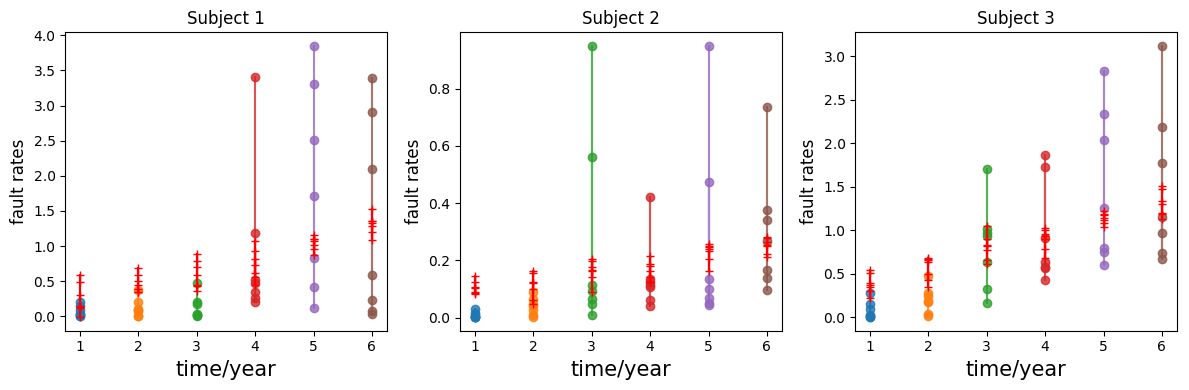

In [25]:
fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(1, 3)

for ip in np.arange(companiesABC):
    ax = plt.subplot(gs[ip])
    xp = elec_year2[ip * 7:(ip + 1) * 7, :]  # 原始数据
    yp = elec_faults2[ip * 7:(ip + 1) * 7, :]
    ax.plot(xp, yp, marker='o', alpha=.8)
    
    yipred_yplot = np.array([Y_PLSpred[ip][i*6:(i+1)*6] for i in np.arange(7)])
    xipred = np.array([np.arange(6)+1 for i in np.arange(7)])
    
    ax.plot(xipred, yipred_yplot[:], 'k+-', color='r')
    plt.xlabel('time/year', fontsize=15)
    plt.ylabel('fault rates', fontsize=12)
    plt.title('Subject %s' % (ip + 1))
    
plt.tight_layout()
plt.show()